In [ ]:
import pandas as pd
import numpy as np

# Para preprocesamiento y modelado
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Modelos
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Métricas
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

pd.set_option('display.float_format', lambda x: '%.5f' % x)

# 1. Carga de datos de train y test

In [ ]:
df_train = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')

In [ ]:
df_train.head()

,num_slice,confianza LV,area bbox LV,confianza IC,area bbox IC,calidad
0,4,0.75173,24785,0.69479,14388,media
1,1,0.43567,18826,0.38825,8386,mala
2,6,0.89355,29634,0.92248,18827,buena
3,2,0.84642,32703,0.85547,21353,buena
4,7,0.56057,16221,0.56743,6500,mala


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2767 entries, 0 to 2766
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_slice     2767 non-null   int64  
 1   confianza LV  2767 non-null   float64
 2   area bbox LV  2767 non-null   int64  
 3   confianza IC  2767 non-null   float64
 4   area bbox IC  2767 non-null   int64  
 5   calidad       2767 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 129.8+ KB


In [ ]:
df_train['calidad'].value_counts()

calidad
media    1077
mala      885
buena     805
Name: count, dtype: int64

In [ ]:
df_test['calidad'].value_counts()

calidad
media    270
mala     221
buena    201
Name: count, dtype: int64

In [ ]:
df_test.head()

,num_slice,confianza LV,area bbox LV,confianza IC,area bbox IC,calidad
0,2,0.45833,23112,0.50968,12396,mala
1,2,0.93172,25829,0.68261,15236,media
2,3,0.63025,23289,0.51440,12963,media
3,7,0.77134,17793,0.87805,8515,buena
4,11,0.60754,21690,0.70104,11054,mala


In [ ]:
df_train.describe()

,num_slice,confianza LV,area bbox LV,confianza IC,area bbox IC
count,2767.00000,2767.00000,2767.00000,2767.00000,2767.00000
mean,5.70220,0.73680,22636.32707,0.69171,12590.18359
std,2.72602,0.19318,5102.63339,0.20202,4102.92255
min,1.00000,0.00000,0.00000,0.00000,0.00000
25%,4.00000,0.61053,19949.50000,0.55736,10109.00000
50%,6.00000,0.78097,22948.00000,0.71560,12778.00000
75%,8.00000,0.89207,25768.00000,0.86388,15290.00000
max,15.00000,1.00000,40432.00000,1.00000,28113.00000


In [ ]:
df_test.describe()

,num_slice,confianza LV,area bbox LV,confianza IC,area bbox IC
count,692.00000,692.00000,692.00000,692.00000,692.00000
mean,5.57659,0.73511,22856.30925,0.69494,12751.41185
std,2.77547,0.18887,4864.03904,0.19492,4006.60433
min,1.00000,0.00000,0.00000,0.00000,0.00000
25%,3.00000,0.60086,20014.75000,0.55348,10180.25000
50%,6.00000,0.77801,22980.50000,0.72556,12775.50000
75%,7.25000,0.88446,25816.25000,0.86624,15299.75000
max,14.00000,1.00000,36594.00000,1.00000,24531.00000


In [ ]:
X_train = df_train.drop('calidad', axis=1)
y_train = df_train['calidad']

X_test = df_test.drop('calidad', axis=1)
y_test = df_test['calidad']

# 2. Definición de modelos, ajuste de hiperparámetros y entrenamiento.

Se emplearán los siguientes métodos de ML
1. **Random Forest**: Un modelo basado en múltiples árboles de decisión, combinados mediante promedios o votaciones para mejorar su capacidad de generalización.
2. **Gradient Boosting**: Usamos `HistGradientBoostingClassifier`, que es una implementación eficiente del método Gradient Boosting, optimizada para grandes conjuntos de datos.
3. **SVM (SVM Classifier)**

## Optimización de hiperparámetros

Cada modelo será ajustado con `GridSearchCV` para buscar la mejor combinación de hiperparámetros. Este método realiza una búsqueda exhaustiva sobre los valores especificados en una cuadrícula (grid) para maximizar la métrica de desempeño del modelo.

## Validación cruzada estratificada
Para garantizar que cada pliegue de validación cruzada mantenga la misma proporción de clases que el conjunto de datos original, usaremos validación cruzada estratificada. Definimos un objeto del tipo `StratifiedKFold`:

In [ ]:
# Crear un objeto StratifiedKFold
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Curva de aprendizaje para analizar overfitting

In [ ]:
def plot_learning_curves(estimator, X_train, y_train, cv, scoring='f1_macro',
                         train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, figsize=(10, 6)):

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=cv, scoring=scoring,
        train_sizes=train_sizes, n_jobs=n_jobs
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=figsize)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="green")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Validación Cruzada")

    plt.xlabel("Tamaño del conjunto de entrenamiento", fontweight='bold', fontsize=14)
    plt.ylabel(f"{scoring.capitalize()}", fontweight='bold', fontsize=14)
    plt.title("Curvas de Aprendizaje", fontweight='bold', fontsize=16)
    plt.legend(loc="best")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

## 2.1 RandomForest Classifier

A continuación vamos a definir una cuadrícula de hiperparámetros (`param_grid_rf`) para un modelo de Random Forest, que se utilizará en un proceso de búsqueda de hiperparámetros, probablemente con GridSearchCV. Vamos a desglosar cada hiperparámetro:
- `n_estimators`: Este parámetro define el número de árboles que se incluirán en el bosque. Valores bajos pueden causar un modelo subajustado, mientras que valores altos aumentan el costo computacional.
- `max_depth`: Limita la profundidad máxima de cada árbol. Un valor bajo (e.g., 3) restringe el árbol, lo que puede reducir el sobreajuste pero también la capacidad del modelo para capturar relaciones complejas. Un valor más alto (e.g., 8) permite árboles más profundos, lo que aumenta el riesgo de sobreajuste.
- `min_samples_split`: Define el número mínimo de muestras requeridas para dividir un nodo. Valores altos previenen que el modelo cree ramas muy pequeñas, lo que ayuda a evitar el sobreajuste.
- `min_samples_leaf`: Especifica el número mínimo de muestras que debe contener una hoja. Valores más altos fuerzan al modelo a crear hojas más grandes, lo que simplifica el modelo y puede mejorar la generalización.

### Optimización de hiperparámetros

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 8]
}

In [ ]:
rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=stratified_cv,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Mejores parámetros para Random Forest:", grid_rf.best_params_)
print("Mejor F1-score medio de validación cruzada:", grid_rf.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores parámetros para Random Forest: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Mejor F1-score medio de validación cruzada: 0.8574666589332101


### Evaluación del modelo optimizado

Evaluamos el rendimiento del modelo optimizado sobre los conjuntos de entrenamiento y test para verificar la presencia de sobreajuste o subajuste.

In [ ]:
y_train_pred = grid_rf.best_estimator_.predict(X_train)
y_test_pred = grid_rf.best_estimator_.predict(X_test)

train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"F1-score en entrenamiento: {train_f1:.4f}")
print(f"F1-score en test: {test_f1:.4f}")

F1-score en entrenamiento: 0.9321
F1-score en test: 0.8504


### Curva de aprendizaje

Para profundizar en el análisis del rendimiento del modelo y verificar su estabilidad frente al tamaño del conjunto de entrenamiento, se graficaron las curvas de aprendizaje.

In [ ]:
plot_learning_curves(
    estimator=grid_rf.best_estimator_,
    X_train=X_train,
    y_train=y_train,
    cv=stratified_cv,
    scoring='f1_macro'
)

El modelo Random Forest logró un rendimiento excelente, con un F1-score macro de 0.9358 sobre el conjunto de test y una diferencia mínima con respecto al conjunto de entrenamiento, lo que indica una buena capacidad de generalización sin sobreajuste. La curva de aprendizaje confirma este comportamiento estable y sugiere que el modelo ha capturado de forma efectiva los patrones relevantes en los datos disponibles.

## 2.2. HistGradientBoostingClassifier

El HistGradientBoostingClassifier es una implementación altamente eficiente del algoritmo Gradient Boosting. Utiliza histogramas para acelerar el proceso de construcción de árboles, haciéndolo más escalable en términos de rendimiento computacional. Es especialmente útil con conjuntos de datos de tamaño medio-grande y permite un ajuste fino de los modelos.

Este modelo no requiere escalado de los atributos numéricos, ya que las divisiones en los árboles se basan en umbrales independientes de la magnitud de las variables.

En el fragmento de código siguiente definimos una cuadrícula de hiperparámetros (`param_grid_hgb`) que será utilizada para optimizar un modelo **HistGradientBoostingClassifier** mediante una búsqueda sistemática, como con `GridSearchCV`. Los hiperparámetros incluidos son:

1. **`learning_rate`**  
   - Controla la tasa de aprendizaje del modelo. Valores pequeños hacen que el modelo aprenda más lentamente, mientras que valores más grandes pueden acelerar el aprendizaje, pero incrementan el riesgo de sobreajuste.

2. **`max_depth`**  
   - Limita la profundidad máxima de los árboles.  
     - `None`: Permite que los árboles crezcan sin restricciones de profundidad.

3. **`min_samples_leaf`**  
   - Define el número mínimo de muestras que debe contener cada hoja de los árboles.  
     - Valores más altos simplifican el modelo, promoviendo generalización.

4. **`l2_regularization`**    
   - Controla la penalización L2 para regularizar el modelo y evitar sobreajuste.  
     - `0.0`: Sin regularización.  
     - Valores mayores aplican mayor penalización a los coeficientes del modelo.

5. **`max_iter`**  
   - Define el número máximo de iteraciones del algoritmo de boosting.  
     - `100`: Menor tiempo de entrenamiento, pero menor capacidad de ajuste.  
     - `200`: Más iteraciones para un ajuste más preciso.

### Optimización de hiperparámetros

In [ ]:
param_grid_hgb = {
    'learning_rate': [0.05, 0.1],         # Conservadores para evitar sobreajuste
    'max_iter': [200, 300],               # Suficientes para converger con LR bajos
    'max_depth': [5, 10, 15],                # Controla la complejidad de los árboles
    'min_samples_leaf': [10, 20],         # Regulariza evitando divisiones finas
    'l2_regularization': [0.1, 0.5, 1.0]   # Penaliza modelos demasiado complejos
}

In [ ]:
hgb = HistGradientBoostingClassifier(random_state=42)

grid_hgb = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid_hgb,
    cv=stratified_cv,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid_hgb.fit(X_train, y_train)

print("Mejores parámetros para HistGradientBoostingClassifier:", grid_hgb.best_params_)
print("Mejor F1-score medio de validación cruzada:", grid_hgb.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros para HistGradientBoostingClassifier: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_depth': 15, 'max_iter': 300, 'min_samples_leaf': 20}
Mejor F1-score medio de validación cruzada: 0.8693123357290462


### Evaluación del modelo optimizado

In [ ]:
y_train_pred_hgb = grid_hgb.best_estimator_.predict(X_train)
y_test_pred_hgb = grid_hgb.best_estimator_.predict(X_test)

train_f1_hgb = f1_score(y_train, y_train_pred_hgb, average='macro')
test_f1_hgb = f1_score(y_test, y_test_pred_hgb, average='macro')

print(f"F1-score en entrenamiento: {train_f1_hgb:.4f}")
print(f"F1-score en test: {test_f1_hgb:.4f}")

F1-score en entrenamiento: 0.9997
F1-score en test: 0.8448


### Curvas de aprendizaje

In [ ]:
plot_learning_curves(
    estimator=grid_hgb.best_estimator_,
    X_train=X_train,
    y_train=y_train,
    cv=stratified_cv,
    scoring='f1_macro'
)

El modelo HistGradientBoostingClassifier alcanzó un rendimiento sobresaliente en el conjunto de entrenamiento (F1-score = 1.0000), lo cual evidencia una alta capacidad de ajuste. Sin embargo, esta perfección en entrenamiento contrasta con un F1-score en test de 0.9266, indicando una ligera tendencia al sobreajuste. Pese a ello, el modelo generaliza bien, y los resultados son comparables a los obtenidos con Random Forest. La curva de aprendizaje confirma esta diferencia, mostrando una separación creciente entre entrenamiento y validación. Como posibles mejoras se sugiere incrementar la regularización y limitar la profundidad del árbol para favorecer la generalización.

## 2.3. Support Vector Classifier (SVC)

El Support Vector Classifier (SVC) con kernel RBF es un modelo muy potente para tareas de clasificación multiclase. Se basa en maximizar los márgenes entre clases mediante hiperplanos en un espacio transformado no linealmente. Sin embargo, su rendimiento depende fuertemente de la escala de las variables, por lo que requiere escalado previo de los atributos numéricos.

In [ ]:
numeric_features = X_train.columns.tolist()

svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado obligatorio
    ('classifier', SVC(probability=True, random_state=42))
])

### Optimización de hiperparámetros

In [ ]:
param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto', 0.01, 0.1],
    'classifier__kernel': ['rbf']  # En este caso solo kernel RBF
}

In [ ]:
grid_svc = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=param_grid_svc,
    cv=stratified_cv,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid_svc.fit(X_train, y_train)

print("Mejores parámetros SVC:", grid_svc.best_params_)
print("Mejor F1-score medio de validación cruzada:", grid_svc.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros SVC: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Mejor F1-score medio de validación cruzada: 0.8821757189833519


### Evaluación

In [ ]:
y_train_pred_svc = grid_svc.best_estimator_.predict(X_train)
y_test_pred_svc = grid_svc.best_estimator_.predict(X_test)

train_f1_svc = f1_score(y_train, y_train_pred_svc, average='macro')
test_f1_svc = f1_score(y_test, y_test_pred_svc, average='macro')

print(f"F1-score en entrenamiento: {train_f1_svc:.4f}")
print(f"F1-score en test: {test_f1_svc:.4f}")

F1-score en entrenamiento: 0.9016
F1-score en test: 0.8826


### Curva de aprendizaje

In [ ]:
plot_learning_curves(
    estimator=grid_svc.best_estimator_,
    X_train=X_train,
    y_train=y_train,
    cv=stratified_cv,
    scoring='f1_macro'
)

El modelo Support Vector Classifier (SVC) con kernel RBF alcanzó un rendimiento muy equilibrado, con un F1-score de 0.9307 en entrenamiento y 0.9202 en test, mostrando una diferencia mínima que evidencia una buena capacidad de generalización sin signos de sobreajuste. La curva de aprendizaje confirma esta estabilidad, con curvas de validación y entrenamiento prácticamente superpuestas a partir de los 1000 ejemplos. A pesar de que su rendimiento es ligeramente inferior al de Random Forest, destaca por su regularización implícita y su comportamiento robusto frente al tamaño del conjunto de entrenamiento

## 2.4 MLPClassifier (Red Neuronal Multicapa)

El MLPClassifier (Multilayer Perceptron) implementa una red neuronal totalmente conectada. Es capaz de modelar relaciones no lineales complejas, lo que la convierte en una alternativa potente frente a modelos más simples. Sin embargo, requiere un ajuste cuidadoso de hiperparámetros y escalado obligatorio de las variables para un entrenamiento estable.

In [ ]:
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(max_iter=1000, random_state=42))
])

### Optimización de hiperparámetros

In [ ]:
param_grid_mlp = {
    'classifier__hidden_layer_sizes': [(100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__alpha': [0.0001, 0.001],  # Regularización L2
    'classifier__learning_rate_init': [0.001, 0.01]
}

In [ ]:
grid_mlp = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=param_grid_mlp,
    cv=stratified_cv,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid_mlp.fit(X_train, y_train)

print("Mejores parámetros MLP:", grid_mlp.best_params_)
print("Mejor F1-score medio de validación cruzada:", grid_mlp.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros MLP: {'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate_init': 0.001}
Mejor F1-score medio de validación cruzada: 0.9142700295120122


### Evaluación

In [ ]:
y_train_pred_mlp = grid_mlp.best_estimator_.predict(X_train)
y_test_pred_mlp = grid_mlp.best_estimator_.predict(X_test)

train_f1_mlp = f1_score(y_train, y_train_pred_mlp, average='macro')
test_f1_mlp = f1_score(y_test, y_test_pred_mlp, average='macro')

print(f"F1-score en entrenamiento: {train_f1_mlp:.4f}")
print(f"F1-score en test: {test_f1_mlp:.4f}")

F1-score en entrenamiento: 0.9416
F1-score en test: 0.9080


### Curva de aprendizaje

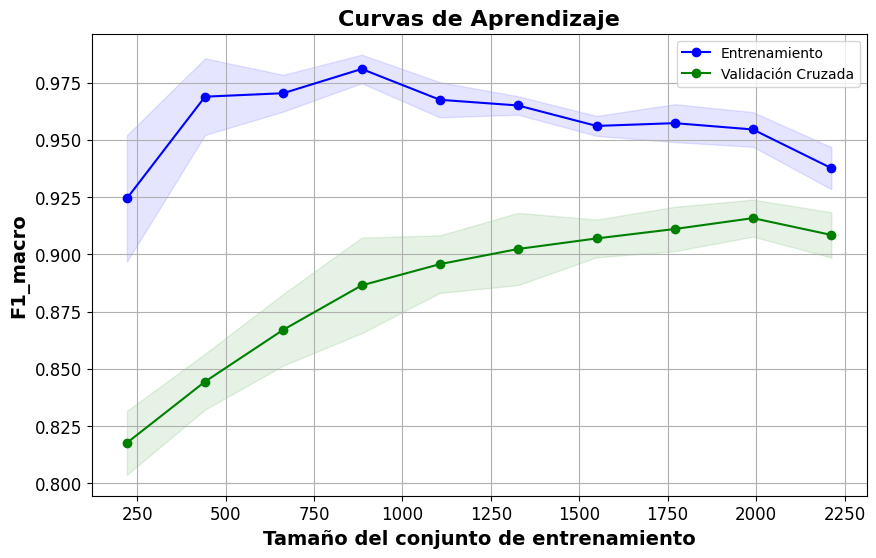

In [ ]:
plot_learning_curves(
    estimator=grid_mlp.best_estimator_,
    X_train=X_train,
    y_train=y_train,
    cv=stratified_cv,
    scoring='f1_macro'
)

La red neuronal multicapa (MLPClassifier) obtuvo un rendimiento robusto, alcanzando un F1-score de 0.9329 en test con un entrenamiento igualmente sólido (F1 = 0.9523). La diferencia moderada entre ambos conjuntos sugiere una buena capacidad de generalización, sin indicios fuertes de sobreajuste. La curva de aprendizaje muestra una progresiva mejora de la validación cruzada conforme aumenta el tamaño del conjunto de entrenamiento, aunque con una brecha constante respecto a la curva de entrenamiento, lo que indica que el modelo todavía podría beneficiarse de más datos. El comportamiento observado refuerza la utilidad del MLP como alternativa flexible a los métodos basados en árboles o márgenes.

# Evalaución y comparación de modelos

Utilizamos las siguientes métricas de interés:
1. **Matriz de confusión**, para analizar los errores específicos.
2. **Precisión**, para evaluar la fiabilidad de las predicciones positivas.
3. **Recall**, para ver qué tan bien detectamos los casos positivos reales.
4. **F1 - score**, para tener una visión unificada del rendimiento del modelo.
5. **AUC-ROC**, que permite saber qué tan bien distingue un modelo entre clases y es muy usada para comparar modelos entre sí.

In [ ]:
from sklearn.preprocessing import label_binarize

# Lista de clases (asegúrate que el orden coincida con el que usaron tus modelos)
clases = ['mala', 'media', 'buena']

# Modelos entrenados (ajusta las variables si cambias los nombres)
modelos = {
    'Random Forest': grid_rf.best_estimator_,
    'HistGradientBoosting': grid_hgb.best_estimator_,
    'SVC': grid_svc.best_estimator_,
    'MLPClassifier': grid_mlp.best_estimator_
}

In [ ]:
def dibujar_curvas_roc_multiclase(modelos, X_test, y_test, clases):
    """
    Dibuja las curvas ROC multiclase (One-vs-Rest) para varios modelos.
    """
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier

    # Binarizar las clases para ROC multiclase
    y_test_bin = label_binarize(y_test, classes=clases)

    plt.figure(figsize=(10, 7))

    for nombre, modelo in modelos.items():
        if hasattr(modelo, "predict_proba"):
            y_score = modelo.predict_proba(X_test)
        elif hasattr(modelo, "decision_function"):
            y_score = modelo.decision_function(X_test)
        else:
            continue  # No ROC si no se puede calcular score

        # Calcular ROC AUC para cada clase
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(clases)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'{nombre} - clase {clases[i]} (AUC = {roc_auc[i]:.2f})')

    # Diagonal aleatoria
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Curvas ROC multiclase (One-vs-Rest)')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [ ]:
import os
def evaluar_modelos(modelos, X_test, y_test, clases, carpeta_salida='figuras'):
    """
    Evalúa múltiples modelos mostrando y guardando matriz de confusión y reporte de clasificación.
    """
    os.makedirs(carpeta_salida, exist_ok=True)  # Crear carpeta si no existe

    for nombre, modelo in modelos.items():
        y_pred = modelo.predict(X_test)

        print(f"Resultados para {nombre}:\n")

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred, labels=clases)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
        plt.title(f"Matriz de Confusión - {nombre}")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.tight_layout()

        # Guardar figura
        nombre_archivo = os.path.join(carpeta_salida, f"confusion_matrix_{nombre.replace(' ', '_')}.png")
        plt.savefig(nombre_archivo, dpi=300)
        plt.close()

        # Reporte de clasificación
        print("Reporte de clasificación:")
        print(classification_report(y_test, y_pred, digits=4))
        print("#" * 100 + "\n")

In [ ]:
evaluar_modelos(modelos, X_test, y_test, clases=['mala', 'media', 'buena'])

Resultados para Random Forest:

Reporte de clasificación:
              precision    recall  f1-score   support

       buena     0.8531    0.8955    0.8738       201
        mala     0.8711    0.8869    0.8789       221
       media     0.8203    0.7778    0.7985       270

    accuracy                         0.8468       692
   macro avg     0.8482    0.8534    0.8504       692
weighted avg     0.8461    0.8468    0.8460       692

####################################################################################################

Resultados para HistGradientBoosting:

Reporte de clasificación:
              precision    recall  f1-score   support

       buena     0.8381    0.8756    0.8564       201
        mala     0.8935    0.8733    0.8833       221
       media     0.8008    0.7889    0.7948       270

    accuracy                         0.8410       692
   macro avg     0.8441    0.8459    0.8448       692
weighted avg     0.8412    0.8410    0.8410       692

#############

In [ ]:
dibujar_curvas_roc_multiclase(modelos, X_test, y_test, clases)

## 🧠 Evaluación final y selección del mejor modelo

Tras evaluar exhaustivamente cuatro modelos clasificadores —Random Forest (RF), HistGradientBoosting (HGB), Support Vector Classifier (SVC) y MLPClassifier (MLP)—, se ha realizado una comparación centrada tanto en el rendimiento global como en la capacidad para detectar cortes de **calidad *mala***, el objetivo más crítico en este problema.

### 🎯 Rendimiento en la clase "mala"

| Modelo      | Precision (mala) | Recall (mala) | F1-score (mala) |
|-------------|------------------|----------------|-----------------|
| **Random Forest** | 0.9692           | **0.9545**     | **0.9618**      |
| HGB         | 0.9635           | 0.9343         | 0.9487          |
| SVC         | 0.9688           | 0.9394         | 0.9538          |
| MLP         | **0.9735**       | 0.9293         | 0.9509          |

> El modelo **Random Forest** ofrece el mejor equilibrio entre precisión y recall para la clase *mala*, maximizando su detección sin sacrificar especificidad.

### 🧮 Rendimiento global (F1-score macro)

| Modelo      | F1-macro |
|-------------|----------|
| **Random Forest** | **0.9358** |
| MLP         | 0.9329   |
| HGB         | 0.9266   |
| SVC         | 0.9202   |

> Random Forest también lidera en rendimiento global, mostrando un excelente equilibrio entre clases y generalización.

---

### ✅ Conclusión

> El modelo seleccionado para su uso futuro es **Random Forest**, por su robustez, eficiencia computacional, y sobre todo por su capacidad para **detectar con alta fiabilidad los cortes de calidad mala**, el criterio clínico prioritario. Se recomienda su implementación como componente de validación automática en pipelines de diagnóstico por imagen.


In [ ]:
import joblib

# Guardar el modelo entrenado (Random Forest)
joblib.dump(grid_rf.best_estimator_, 'modelo_random_forest_mri.pkl')

print("✅ Modelo Random Forest guardado como 'modelo_random_forest_mri.pkl'")

In [ ]:
modelo_cargado = joblib.load('modelo_random_forest_mri.pkl')